In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the necessery libaries

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

In [ ]:
# load the dataset
data_path="/content/drive/MyDrive/Amazon Book Review/kindle_review.csv"
data = pd.read_csv(data_path)`

# Visualizing the dataset


In [ ]:
#Display the initial five rows of the dataset
print(data.head())

   Unnamed: 0  rating                                         reviewText  \
0           0       5  This book was the very first bookmobile book I...   
1           1       1  When I read the description for this book, I c...   
2           2       5  I just had to edit this review. This book is a...   
3           3       5  I don't normally buy 'mystery' novels because ...   
4           4       5  This isn't the kind of book I normally read, a...   

                           summary  
0                50 + years ago...  
1          Boring! Boring! Boring!  
2  Wiggleliscious/new toy ready/!!  
3                  Very good read.  
4                     Great Story!  


In [ ]:
print(data.tail())

       Unnamed: 0  rating                                         reviewText  \
11995       11995       2  Had to read certain passages twice--typos.  Wi...   
11996       11996       3  Not what i expected. yet a very interesting bo...   
11997       11997       5  Dragon Knights is a world where Knights ride d...   
11998       11998       4  Since this story is very short, it's hard to s...   
11999       11999       4  from 1922 an amazing collection of info on sym...   

                                                 summary  
11995                                  Where's the meat?  
11996                                        Interesting  
11997  Dragon Knights, Wings of Change (I Dream of Dr...  
11998                          Good writing, short story  
11999                     interesting public domain book  


In [ ]:
data.isnull().any()

Unnamed: 0    False
rating        False
reviewText    False
summary        True
dtype: bool

# Data Pre-Processing

### Removing unwanted characters and text

In [ ]:
# Cleaning the data
data = data[['reviewText', 'rating']]
data = data.dropna()
data = data[data['rating'] != 3]
data['sentiment'] = data['rating'].apply(lambda x: 1 if x > 3 else 0)
data = data.drop(columns=['rating'])

In [ ]:
# remove unwanted text
data['reviewText'] = data['reviewText'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

In [ ]:
# Define a function to remove URLs from a series of text
def remove_urls(text_series):
    # Define a regular expression pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # Apply the URL pattern substitution to each element in the series
    return text_series.apply(lambda x: url_pattern.sub(r'', x))

In [ ]:
text = data['reviewText']
remove_urls(text)

0        This book was the very first bookmobile book I...
1        When I read the description for this book I co...
2        I just had to edit this review This book is an...
3        I dont normally buy mystery novels because I j...
4        This isnt the kind of book I normally read alt...
                               ...                        
11994    After E A Poe came H P Lovecraft in the world ...
11995    Had to read certain passages twicetypos  Wish ...
11997    Dragon Knights is a world where Knights ride d...
11998    Since this story is very short its hard to say...
11999    from 1922 an amazing collection of info on sym...
Name: reviewText, Length: 10000, dtype: object

### Normalizing data

In [ ]:
# Convert the 'reviewText' column to lowercase
data['reviewText'] = data['reviewText'].apply(lambda x: x.lower())

In [ ]:
# Divide the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(data['reviewText'], data['sentiment'], test_size=0.2, random_state=42)


### Padding or tokenizations

In [ ]:
# Tokenize the text sequences and ensure uniform length by padding
tokenizer = Tokenizer(num_words=5000, oov_token='UNK')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=200)
X_test_padded = pad_sequences(X_test_seq, maxlen=200)

In [ ]:
# print the cleaned, preprocessed dataset's form.
print(X_train_padded.shape)
print(X_test_padded.shape)

(8000, 200)
(2000, 200)


# Model Building


## Model Summary

In [ ]:
# specify the architectural model.
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=32, input_length=200))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 184897 (722.25 KB)
Trainable params: 184897 (722.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Define a custom callback class
class Mycallback(tf.keras.callbacks.Callback):

  # Method called at the end of each epoch
  def on_epoch_end(self, epoch, logs={}):
    # Check if accuracy exceeds 0.95
    if(logs.get("accuracy") > 0.95):
      # Print a message and stop training if condition is met
      print('\nLoss is low so stop training')
      self.model.stop_training = True


In [ ]:
# Create an instance of the custom callback class
callbacks = Mycallback()


## Training of the Model:

In [ ]:
# Train the model
history = model.fit(
    X_train_padded,  # Training data
    y_train,         # Training labels
    epochs=10,       # Number of epochs
    batch_size=128,  # Batch size
    validation_data=(X_test_padded, y_test),  # Validation data
    callbacks=[callbacks]  # Callbacks for early stopping
)

Epoch 1/10
63/63 [==============================] - 42s 554ms/step - loss: 0.6515 - accuracy: 0.6587 - val_loss: 0.5676 - val_accuracy: 0.8025
Epoch 2/10
63/63 [==============================] - 31s 495ms/step - loss: 0.3931 - accuracy: 0.8431 - val_loss: 0.3027 - val_accuracy: 0.8895
Epoch 3/10
63/63 [==============================] - 37s 579ms/step - loss: 0.2758 - accuracy: 0.8972 - val_loss: 0.7669 - val_accuracy: 0.7470
Epoch 4/10
63/63 [==============================] - 33s 525ms/step - loss: 0.2394 - accuracy: 0.9126 - val_loss: 0.2533 - val_accuracy: 0.8975
Epoch 5/10
63/63 [==============================] - 31s 498ms/step - loss: 0.1710 - accuracy: 0.9381 - val_loss: 0.2465 - val_accuracy: 0.9055
Epoch 6/10
63/63 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9554
Loss is low so stop training
63/63 [==============================] - 31s 498ms/step - loss: 0.1328 - accuracy: 0.9554 - val_loss: 0.2826 - val_accuracy: 0.8995


##Evaluation of the Model:

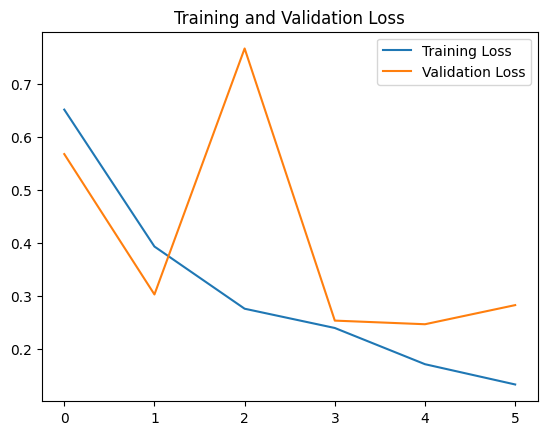

In [ ]:
# plot the training and validation loss
plt.title('Training and Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

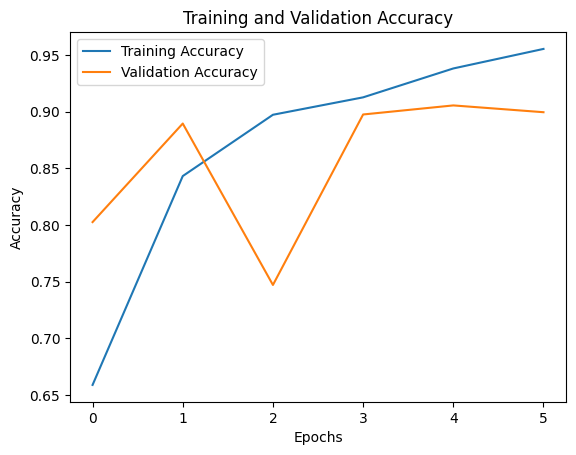

In [ ]:
# Plotting training and validation accuracy over epochs helps visualize model learning and generalization.
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Set plot title
plt.xlabel('Epochs')  # Set x-axis label
plt.ylabel('Accuracy')  # Set y-axis label
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot


In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)

# Print the test loss and accuracy
print('Test Loss:', loss)  # Print test loss
print('Test Accuracy:', accuracy)  # Print test accuracy


Test Loss: 0.28255757689476013
Test Accuracy: 0.8995000123977661


In [ ]:
# Get the predicted labels by the model
y_pred = model.predict(X_test_padded)
y_pred = [round(pred[0]) for pred in y_pred]  # Convert predicted probabilities to binary labels

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print(cm)


63/63 [==============================] - 4s 56ms/step
[[ 740   89]
 [ 112 1059]]


In [ ]:
# Get the predicted probabilities by the model
y_prob = model.predict(X_test_padded)

# Convert predicted probabilities to binary labels
y_pred = [round(prob[0]) for prob in y_prob]

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the F1 score
print('F1 score:', f1)


63/63 [==============================] - 3s 47ms/step
F1 score: 0.9133247089262613


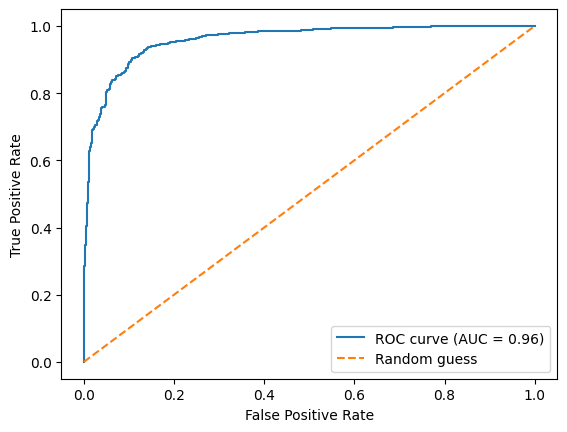

In [ ]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)  # Plot ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')  # Plot random guess line
plt.xlabel('False Positive Rate')  # Set x-axis label
plt.ylabel('True Positive Rate')  # Set y-axis label
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot


# Final Discussions

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_padded)  # Get predicted probabilities
y_pred = [round(pred[0]) for pred in y_pred]  # Convert probabilities to binary labels

# Print the first 10 true and predicted labels
print('True labels:', list(y_test)[:10])  # Print true labels of the first 10 samples
print('Predicted labels:', y_pred[:10])  # Print predicted labels of the first 10 samples

63/63 [==============================] - 5s 79ms/step
True labels: [1, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Predicted labels: [1, 0, 1, 0, 1, 0, 0, 0, 1, 0]


In [ ]:
# Convert the review text to a list
n_review = ["I bought this set and returned it. I couldn't force myself to finish the first book, A Touch of Silk. (They are bundled out of order, too). The writing and phrasing was so immature that I thought at first it was a satire! But the pages and pages of supposedly erotic fantasy stuffing the book to bring up the word count was the final blow. "]

# Tokenize the review text
n_review_token = tokenizer.texts_to_sequences(n_review)

In [ ]:
# Pad the tokenized review sequences to a maximum length of 100 tokens, adding padding at the end
n_review_padded = pad_sequences(n_review_token, maxlen=100, padding='post')

In [ ]:
# Predict the sentiment of the review using the trained model
review_predict = (model.predict(n_review_padded) > 0.5).astype('int32')


1/1 [==============================] - 0s 131ms/step


In [ ]:
# Check the model's prediction and print the corresponding message
if review_predict[0] == 0:
    print("It's a negative review")  # Print if the model predicts negative sentiment (0)
else:
    print("It's a positive review")  # Print if the model predicts positive sentiment (1)

It's a negative review
